In [1]:
import os
import tqdm
import numpy as np
import tensorflow as tf
from sklearn.metrics import precision_recall_curve, f1_score, accuracy_score
import matplotlib.pyplot as plt
from src.models.resnet import ResNet18
from src.libs.data_loading import create_dataset_classification

2024-11-28 23:10:48.204275: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-28 23:10:48.234047: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-28 23:10:48.234075: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-28 23:10:48.234099: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-28 23:10:48.239462: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-28 23:10:48.240258: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
data_path = "ssl_images/data"
data_dir = os.path.join(data_path, "processed", "pascal_voc")
metadata_dir = os.path.join(data_path, "pascal_voc", "ImageSets", "Main")

model = ResNet18((224, 224, 3), mode="classification", num_classes=1)
model.load_weights('classification_ckpt/classification_ckpt_CE_person/segmentation_model_epoch_007.weights.h5')

2024-11-28 23:10:53.116666: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-28 23:10:53.117081: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Evaluate on validation dataset

In [3]:
val_dataset = create_dataset_classification(
    data_dir,
    split_list_file=os.path.join(metadata_dir, "val.txt"),
    batch_size=32,
    single_channel=False,
    classes=['person']
)

In [4]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False, label_smoothing=0.1),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC(multi_label=True, name="auc_roc"),
        tf.keras.metrics.AUC(curve="PR", name="average_precision"),
    ],
)

In [5]:
model.evaluate(val_dataset)

182/182 [==============================] - 80s 423ms/step - loss: 0.7056 - binary_accuracy: 0.6636 - precision: 0.5717 - recall: 0.4879 - auc_roc: 0.6901 - average_precision: 0.5922


[0.7056241631507874,
 0.6635754704475403,
 0.5716535449028015,
 0.4879032373428345,
 0.6901428699493408,
 0.5921595096588135]

## Threshold for maximum F1

In [6]:
scores = []
samples = []
labels = []

for batch_images, batch_labels in val_dataset:
    predictions = model.predict(batch_images, verbose=0)
    pred_scores = np.squeeze(predictions)
    
    scores.extend(pred_scores)
    samples.extend(batch_images)
    labels.extend(batch_labels)

scores = np.array(scores)
samples = np.array(samples)
labels = np.array(labels)

In [9]:
precision, recall, thresholds = precision_recall_curve(labels, scores)
f1_scores = 2 * (precision * recall) / (precision + recall)

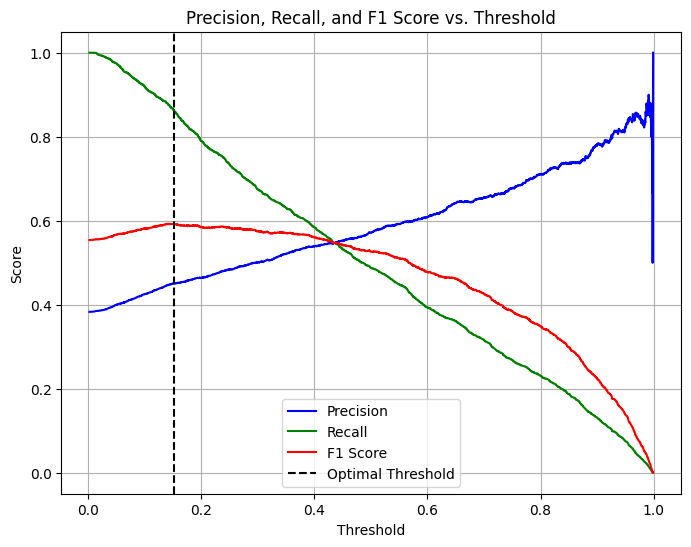

Best Threshold: 0.15
Max F1 Score: 0.59
Precision at best threshold: 0.45
Recall at best threshold: 0.86
Binary accuracy: 0.55


In [10]:
best_f1_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_f1_idx]

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label="Precision", color="blue")
plt.plot(thresholds, recall[:-1], label="Recall", color="green")
plt.plot(thresholds, f1_scores[:-1], label="F1 Score", color="red")
plt.axvline(x=best_threshold, color="black", linestyle="--", label="Optimal Threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1 Score vs. Threshold")
plt.legend(loc="best")
plt.grid()
plt.show()

y_pred_optimal = (scores >= best_threshold).astype(int)

print(f"Best Threshold: {best_threshold:.2f}")
print(f"Max F1 Score: {f1_scores[best_f1_idx]:.2f}")
print(f"Precision at best threshold: {precision[best_f1_idx]:.2f}")
print(f"Recall at best threshold: {recall[best_f1_idx]:.2f}")
print(f"Binary accuracy: {accuracy_score(labels, y_pred_optimal):.2f}")

## T-SNE visualization

In [11]:
embedding_model = tf.keras.models.Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [12]:
all_y = []
all_embeddings = []
for batch in tqdm.tqdm(val_dataset):
    x, y = batch
    pred = embedding_model.predict(x, verbose=0)
    all_y.extend(y)
    all_embeddings.extend(pred)

all_y = np.array(all_y)
all_embeddings = np.array(all_embeddings)

100%|█████████████████████████████████████████████████████████████████████████████████| 182/182 [01:46<00:00,  1.70it/s]


In [13]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=50)
features = tsne.fit_transform(all_embeddings)

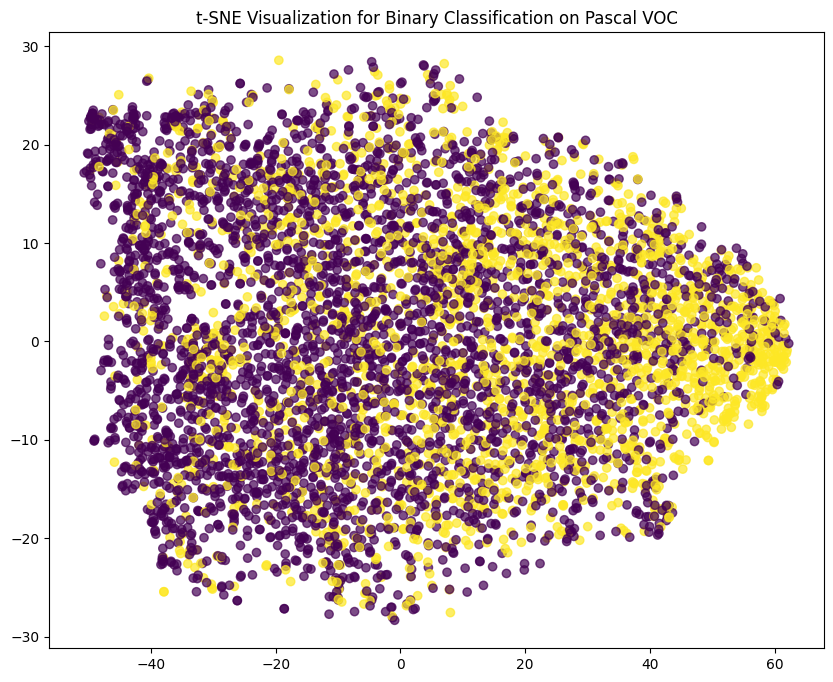

In [14]:
# Plot the results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(features[:, 0], features[:, 1], c=all_y, cmap='viridis', alpha=0.7)
plt.title("t-SNE Visualization for Binary Classification on Pascal VOC")
plt.show()

## Visualize samples by confidence

In [15]:
# Sort indices by score
sorted_indices = np.argsort(scores)

num_samples = 5  # Number of samples to visualize

highest_score_indices = sorted_indices[-num_samples:]
lowest_score_indices = sorted_indices[:num_samples]

# Intermediate confidence samples (~50%)
threshold_low = 0.48
threshold_high = 0.52
intermediate_score_indices = np.where((scores >= threshold_low) & (scores <= threshold_high))[0]
intermediate_score_indices = intermediate_score_indices[:num_samples]

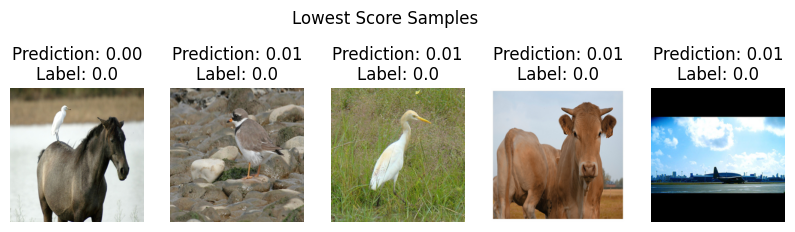

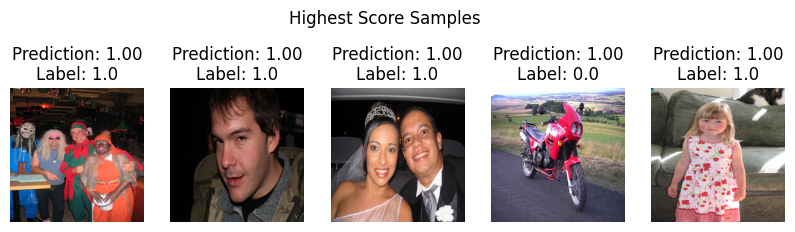

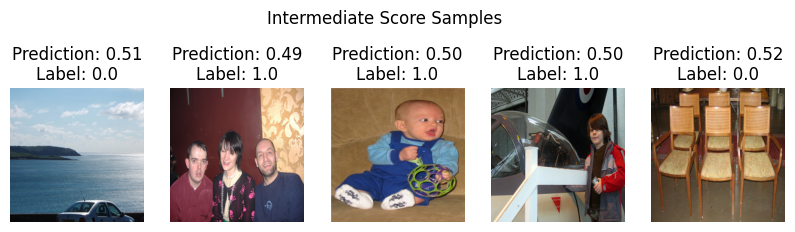

In [16]:
def visualize_samples(indices, title):
    plt.figure(figsize=(10, 3))
    for i, idx in enumerate(indices):
        plt.subplot(1, len(indices), i + 1)
        plt.imshow(samples[idx])
        plt.title(f"Prediction: {scores[idx]:.2f}\nLabel: {labels[idx][0]}")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()
    
# Visualize lowest score samples
visualize_samples(lowest_score_indices, "Lowest Score Samples")

# Visualize highest score samples
visualize_samples(highest_score_indices, "Highest Score Samples")

# Visualize intermediate score samples
visualize_samples(intermediate_score_indices, "Intermediate Score Samples")